In [9]:
# -*-coding:utf-8-*-
%matplotlib inline
import os

import numpy as np
from matplotlib import pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB

from bald_latin import remove_cyrillic_and_accents
from dataset import CommentDataset

### Load the original and stemmed comments, and their labels.
Remove the cyrillic comments and remove accents from ć,č,ž,š,đ.

In [2]:
originals = open('dataset/lns/lns_comments.txt', 'r').readlines()
corpus = open('dataset/lns/lns_comments_stemmed.txt', 'r').readlines()
labels = open('dataset/lns/lns_labels.txt', 'r').readlines()

# remove cyrillic and balden text
corpus, labels = remove_cyrillic_and_accents(corpus, labels)
originals, _ = remove_cyrillic_and_accents(originals, range(len(originals)), remove_accents=False)

# labels as a numpy array
labels = np.array([int(float(x)) for x in labels])

# Train a Naive Bayes classifier using K-Fold crossvalidation
### Test it on each test set, average the results

Results on 3 folds:
Accuracy: 0.720954987835,
Precision: 0.715144801065,
Recall: 0.818564646503


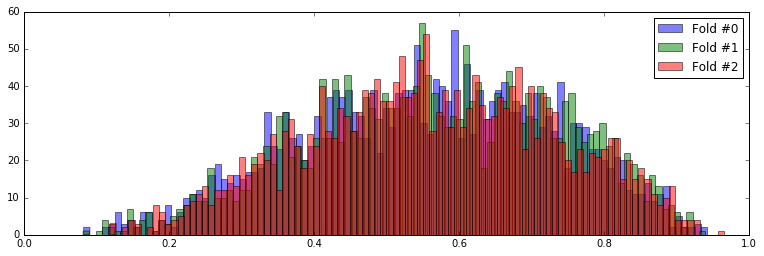

In [20]:
n_folds=3
values = np.zeros(3)  # accuracy, precision, recall
probabilities = []

k_fold = KFold(len(corpus), n_folds=n_folds, shuffle=True)
for fold_count, (train, test) in enumerate(k_fold):
#     print "Fold #{}".format(fold_count)
    corpus_train = [corpus[x] for x in train]
    corpus_test = [corpus[x] for x in test]
    labels_train = [labels[x] for x in train]
    labels_test = [labels[x] for x in test]
    
    # build the dataset, vectorize it using TF-IDF
    data = CommentDataset(corpus_train, labels_train, corpus_test, labels_test)
    data.vectorize()
        
    # create and fit the classifier
    clf = MultinomialNB().fit(data.X_train, data.y_train)
    
    proba = clf.predict_proba(data.X_test)[:,1]
    probabilities.append(proba)
    
    values += data.test_prediction(proba, print_options=[])[:3]  # for averaging metrics on k-folds
    
print "Results on {} folds:".format(fold_count + 1)
print ("Accuracy: {},\nPrecision: {},\nRecall: {}".format(values[0]/n_folds, values[1]/n_folds, values[2]/n_folds))


# plots
plt.figure(figsize=(13, 4))
for fold, proba in enumerate(probabilities):
    n, bins, patches = plt.hist(proba, 100, alpha=0.5, label="Fold #{}".format(fold))
plt.legend(loc='upper right')
plt.show()
    

In [4]:
cutoff = 0.8
lower = 0.0
upper = 0.9

k_fold = KFold(X.shape[0], n_folds=10, shuffle=True)
for fold_count, (train, test) in enumerate(k_fold):
    X_train = X[train]
    y_train = labels[train]
    X_test = X[test] 
    y_test = labels[test]
    # original comments for the test set
    comments_test = [originals[x] for x in test]
    
    # create and fit the classifier
    clf = MultinomialNB().fit(X_train, y_train)
    
    # predict probabilities on the training set
    proba = clf.predict_proba(X_train)[:, 1]
    training_error = np.mean(np.round(proba) == np.round(y_train)) * 100
    # predict probabilities on the test set
    proba = clf.predict_proba(X_test)[:, 1]
    
    # get the classification error
#     indices = np.argwhere(np.logical_or(proba >= cutoff, proba <= 1 - cutoff))
    indices = np.argwhere(np.logical_or(proba >= upper, proba <= lower))
    y_pred = np.round(proba)
    count = np.sum(indices)
    print "\nFold #{}, classifying {} comments".format(fold_count, len(y_test))
    
#     print confusion_matrix(y_test, y_pred)
    print confusion_matrix(y_test[indices], y_pred[indices])
    
    
#     print "Classification accuracy: {:.2f}%, comments classified: {} ({:.2f}% overall)\n".format(accuracy, count, 100.0*count/len(y_test))
    
    # print out misclassified comments
#     for prob, label, text in zip(proba, y_test, originals):
#         # only take into account comments with high classification certainty.
#         # probability must fall in range [0, 1-cutoff] or [cutoff, 1] for the classification to be taken into account.
#         if prob >= cutoff or prob <= 1 - cutoff:
#             # if the comment is misclassified, print it
#             if np.round(prob) != label:
#                 cls = "bot" if prob > 0.5 else "not"
#                 real = "bot" if label > 0.5 else "not"
                
#                 print "Classified as '%s', label is '%s', comment: \n%s" % (cls, real, text)

    



Fold #0, classifying 658 comments
[[0 1]
 [0 5]]

Fold #1, classifying 658 comments
[[0 1]
 [0 7]]

Fold #2, classifying 658 comments
[[10]]

Fold #3, classifying 658 comments
[[6]]

Fold #4, classifying 658 comments
[[10]]

Fold #5, classifying 658 comments
[[10]]

Fold #6, classifying 657 comments
[[3]]

Fold #7, classifying 657 comments
[[4]]

Fold #8, classifying 657 comments
[[5]]

Fold #9, classifying 657 comments
[[13]]


In [5]:
max_scraped = 10**4
original_scraped = open('dataset/comments.txt', 'r').readlines()
scraped = open('dataset/stemmed.txt', 'r').readlines()
scraped, original_scraped = bald_latin.remove_cyrillic_comments(scraped, original_scraped)
scraped = bald_latin.remove_serbian_accents(scraped)

Cyrillic comments make up 2.22219306384 percent


In [31]:
clf = MultinomialNB().fit(X, labels)

import codecs
output = codecs.open('bot_clf.txt', 'w', 'utf-8')

threshold = 0.85

assert len(scraped) == len(original_scraped)
for comment, org in zip(scraped, original_scraped):
    X_next = vectorizer.transform([comment])
    y_next = clf.predict_proba(X_next)[0][1]
    
    if y_next > threshold:
        org = org.decode('utf-8')
        org = org.replace(u'\n', u' ')
        output.write(org + u'\n')
        
output.close()

In [29]:
output.close()